# Generating Music with RNN

Sources:
- https://www.tensorflow.org/tutorials/audio/music_generation

## Setup

In [1]:
!sudo apt install -y fluidsynth
%pip install --upgrade pyfluidsynth
%pip install pretty_midi

[sudo] password for keegan-jebb: 
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [8]:
import os
import urllib.request
import zipfile
from pathlib import Path

# Define the directory where data will be stored
# data_dir = Path('data/maestro-v2.0.0')
data_dir = Path('/home/keegan-jebb/Documents/projects/misc_data/maestro-v3.0.0')

# Check if the data directory already exists
if not data_dir.exists():
    os.makedirs(data_dir)

    # URL of the file to be downloaded
    url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'

    # Define the local path where the zip file will be saved
    zip_path = Path('data/maestro-v2.0.0-midi.zip')

    # Download the file from the given URL
    print(f'Downloading {url}...')
    urllib.request.urlretrieve(url, zip_path)

    # Extract the contents of the zip file
    print('Extracting files...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data/')

    # Remove the zip file after extraction
    os.remove(zip_path)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## MIDI Processing

In [10]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


In [11]:
# from google.colab import files
sample_file = filenames[1]
print(sample_file)
# files.download(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

/home/keegan-jebb/Documents/projects/misc_data/maestro-v3.0.0/2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--2.midi


In [12]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [13]:
display_audio(pm)

In [14]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
print('Program:', instrument.program)
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

Number of instruments: 1
Program: 0
Instrument name: Acoustic Grand Piano
0: pitch=63, note_name=D#4, duration=0.3346
1: pitch=39, note_name=D#2, duration=0.1654
2: pitch=58, note_name=A#3, duration=0.1367
3: pitch=46, note_name=A#2, duration=0.2148
4: pitch=51, note_name=D#3, duration=0.1549
5: pitch=54, note_name=F#3, duration=0.1914
6: pitch=46, note_name=A#2, duration=0.0768
7: pitch=39, note_name=D#2, duration=0.0846
8: pitch=51, note_name=D#3, duration=0.0534
9: pitch=54, note_name=F#3, duration=0.0599


In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     63  0.278646  0.613281  0.000000  0.334635
1     39  0.945312  1.110677  0.666667  0.165365
2     46  0.945312  1.160156  0.000000  0.214844
3     58  1.006510  1.143229  0.061198  0.136719
4     51  1.014323  1.169271  0.007812  0.154948

In [17]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#2', 'A#2', 'A#3', 'D#3', 'F#3', 'A#2', 'A#3', 'D#2',
       'D#3'], dtype='<U3')

In [18]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [19]:
a = np.stack([raw_notes['pitch'], raw_notes['pitch']], axis=0)
print(a)
a = np.stack([raw_notes['start'], raw_notes['end']], axis=0)
print(a)

[[63 39 46 ... 46 55 63]
 [63 39 46 ... 46 55 63]]
[[2.78645833e-01 9.45312500e-01 9.45312500e-01 ... 2.85233073e+02
  2.85622396e+02 2.86479167e+02]
 [6.13281250e-01 1.11067708e+00 1.16015625e+00 ... 2.91421875e+02
  2.90856771e+02 2.91858073e+02]]


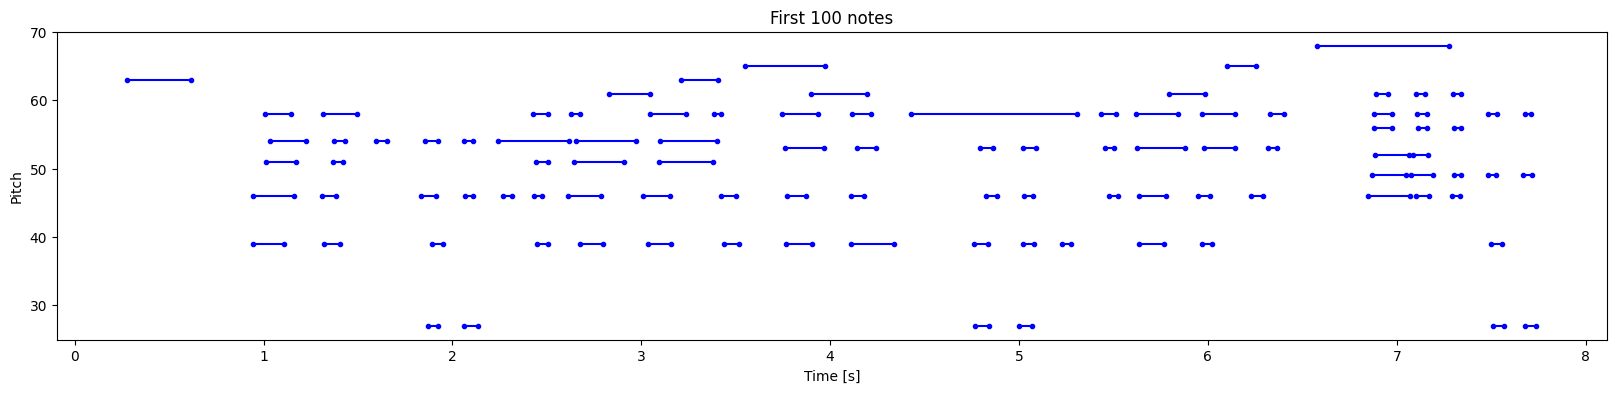

In [20]:
plot_piano_roll(raw_notes, 100)

In [21]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

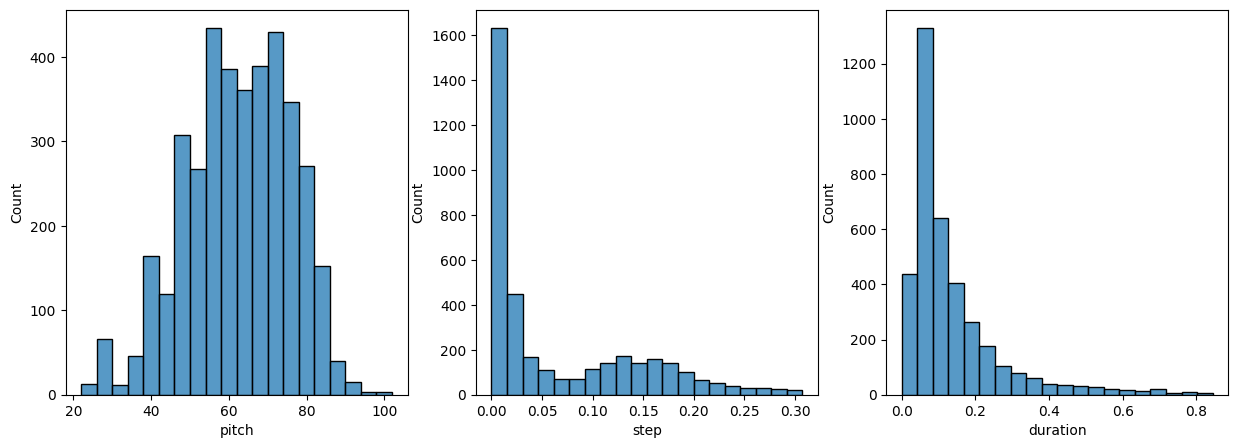

In [22]:
plot_distributions(raw_notes)

In [23]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [25]:
display_audio(example_pm)

### Playing Around

In [26]:
# Print an empirical estimate of its global tempo
print(pm.estimate_tempo())

# Compute the relative amount of each semitone across the entire song,
# a proxy for key
total_velocity = sum(sum(pm.get_chroma()))
print([sum(semitone)/total_velocity for semitone in pm.get_chroma()])

# Shift all notes up by 5 semitones
for instrument in pm.instruments:
    # Don't want to shift drum notes
    if not instrument.is_drum:
        for note in instrument.notes:
            note.pitch += 5

# Synthesize the resulting MIDI data using sine waves
# audio_data = pm.synthesize()

display_audio(pm)

210.8924485125858
[0.046556975436556534, 0.0702037139704806, 0.05492464730636966, 0.18210819303582615, 0.03512334464161947, 0.08332705592614302, 0.11154138650812032, 0.05001538931299201, 0.07699625516543114, 0.06018021062542632, 0.16293876176647581, 0.06608406630455896]


In [27]:
# Create a PrettyMIDI object
cello_c_chord = pretty_midi.PrettyMIDI()

# Create an Instrument instance for a cello instrument
cello_program = pretty_midi.instrument_name_to_program('Cello')
print('Program:', cello_program)
cello = pretty_midi.Instrument(program=cello_program)

# Iterate over note names, which will be converted to note number later
for note_name in ['C2', 'E2', 'G2']:
    # Retrieve the MIDI note number for this note name
    note_number = pretty_midi.note_name_to_number(note_name)

    # Create a Note instance, starting at 0s and ending at 1.5s
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=0, end=2)

    # Add it to our cello instrument
    cello.notes.append(note)

# Add the cello instrument to the PrettyMIDI object
cello_c_chord.instruments.append(cello)

# Write out the MIDI data
# cello_c_chord.write('cello-C-chord.mid')

display_audio(cello_c_chord)

Program: 42


In [28]:
# Create a PrettyMIDI object
drums = pretty_midi.PrettyMIDI()
drum = pretty_midi.Instrument(program=9, is_drum=True)
print(drum.is_drum)

# hits per quarter note
hpq = 3

for i in range(32):
    note_number = pretty_midi.note_name_to_number('B1')
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=i/(2**hpq), end=i/(2**hpq))
    drum.notes.append(note)

hpq = 2
for i in range(8):
    note_number = pretty_midi.note_name_to_number('D2')
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=i/(2**hpq), end=i/(2**hpq))
    drum.notes.append(note)

hpq = 1
for i in range(4):
    note_number = pretty_midi.note_name_to_number('A3')
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=i+1, end=i+1)
    drum.notes.append(note)


drums.instruments.append(drum)
display_audio(drums)

True


fluidsynth: error: There is no preset with bank number 128 and preset number 9 in SoundFont 1


## Data Processing

In [125]:
def get_midi_data(filenames, num_files):
    all_notes = []
    file_id = 0
    for f in filenames[:num_files]:
        notes = midi_to_notes(f)
        notes['file_id'] = file_id
        all_notes.append(notes)
        file_id += 1

    return all_notes

In [57]:
num_files = 50
all_notes = get_midi_data(filenames, num_files)

all_notes_cat = pd.concat(all_notes)

n_notes = len(all_notes_cat)
print('Number of notes parsed:', n_notes)

all_notes_cat.head(26)

Number of notes parsed: 3218821


pitch     start       end      step  duration  file_id
0      22  0.955729  1.052083  0.000000  0.096354        0
1      34  0.962240  1.078125  0.006510  0.115885        0
2      41  1.299479  1.417969  0.337240  0.118490        0
3      46  1.423177  1.606771  0.123698  0.183594        0
4      50  1.531250  1.638021  0.108073  0.106771        0
5      52  1.658854  1.696615  0.127604  0.037760        0
6      53  1.764323  1.885417  0.105469  0.121094        0
7      58  1.886719  2.013021  0.122396  0.126302        0
8      62  1.889323  1.986979  0.002604  0.097656        0
9      55  2.013021  2.141927  0.123698  0.128906        0
10     53  2.123698  2.157552  0.110677  0.033854        0
11     50  2.260417  2.348958  0.136719  0.088542        0
12     46  2.389323  2.429688  0.128906  0.040365        0
13     41  2.430990  2.550781  0.041667  0.119792        0
14     34  2.575521  2.678385  0.144531  0.102865        0
15     41  2.678385  2.825521  0.102865  0.147135        0
16     46  2.792969  2.901042  0.114583  0.108073        0
17     50  2.890625  2.936198  0.097656  0.045573        0
18     52  3.022135  3.132812  0.131510  0.110677        0
19     53  3.111979  3.213542  0.089844  0.101562        0
20     62  3.205729  3.300781  0.093750  0.095052        0
21     58  3.209635  3.324219  0.003906  0.114583        0
22     55  3.324219  3.429688  0.114583  0.105469        0
23     53  3.446615  3.476562  0.122396  0.029948        0
24     50  3.533854  3.630208  0.087240  0.096354        0
25     46  3.631510  3.716146  0.097656  0.084635        0

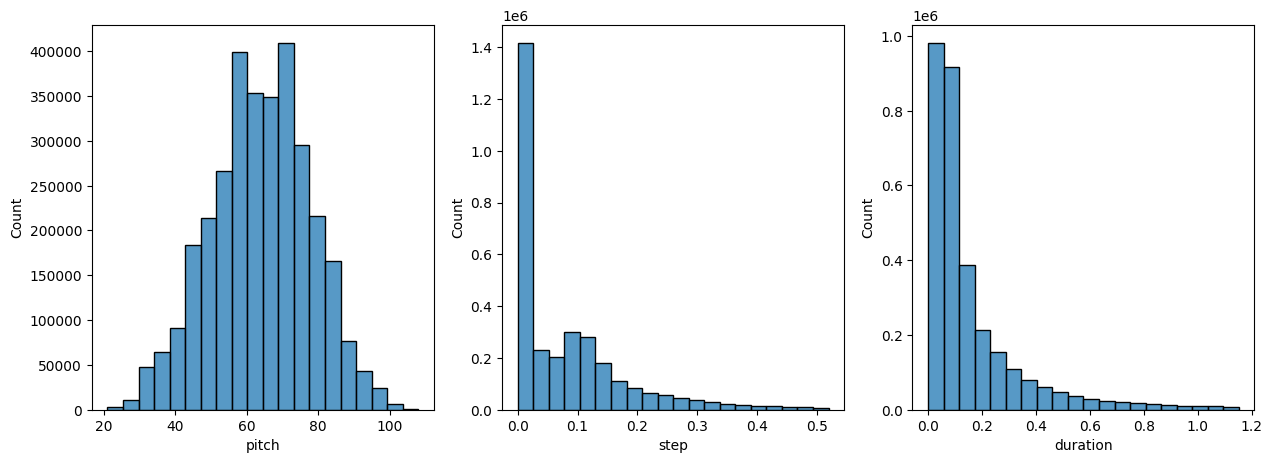

In [60]:
plot_distributions(all_notes_cat)

In [61]:
# Cell not used
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes_cat[key] for key in key_order], axis=1)
# Alternative method: train_notes = np.array(all_notes_cat[key_order])
print(train_notes)

[[2.20000000e+01 0.00000000e+00 9.63541667e-02]
 [3.40000000e+01 6.51041667e-03 1.15885417e-01]
 [4.10000000e+01 3.37239583e-01 1.18489583e-01]
 ...
 [8.40000000e+01 1.39322917e-01 5.33854167e-02]
 [8.70000000e+01 1.41927083e-01 1.21093750e+00]
 [9.20000000e+01 3.37239583e-01 7.98567708e+00]]


## Train/Val/Test Sets

In [62]:
seq_length = 25
vocab_size = 128
take_last = True

In [63]:
from torch.utils.data import Dataset, random_split, DataLoader

class MidiSequenceDataset(Dataset):
    def __init__(self, all_notes, seq_length, vocab_size=128, take_last=True):
        self.seq_length = seq_length + 1  # Include 1 extra for labels
        self.vocab_size = vocab_size
        self.sequences = self.create_sequences(all_notes)

    def create_sequences(self, all_notes):
        sequences = []
        key_order = ['pitch', 'step', 'duration']
        for notes in all_notes:
            notes = notes[key_order]
            for i in range(len(notes) - self.seq_length + 1):
                seq = torch.tensor(notes[i:i + self.seq_length].values, dtype=torch.float32)
                sequences.append(seq)
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        input = sequence[:-1].clone()
        input[:, 0] /= self.vocab_size
        targets = {
            'pitch': sequence[1:, 0].to(torch.long),
            'step': sequence[1:, 1],
            'duration': sequence[1:, 2]
        }
        if take_last:
            for key in targets:
                targets[key] = targets[key][-1]
        return input, targets

In [64]:
midi_ds = MidiSequenceDataset(all_notes, seq_length, vocab_size, take_last)
print(len(midi_ds))

3206321


In [65]:
midi_iter = iter(midi_ds)
seq, target = next(midi_iter)
print('sequence shape:', seq.shape)
print('sequence elements (first 10):', seq[0: 10])
print()
print('target:', target)

sequence shape: torch.Size([25, 3])
sequence elements (first 10): tensor([[0.1719, 0.0000, 0.0964],
        [0.2656, 0.0065, 0.1159],
        [0.3203, 0.3372, 0.1185],
        [0.3594, 0.1237, 0.1836],
        [0.3906, 0.1081, 0.1068],
        [0.4062, 0.1276, 0.0378],
        [0.4141, 0.1055, 0.1211],
        [0.4531, 0.1224, 0.1263],
        [0.4844, 0.0026, 0.0977],
        [0.4297, 0.1237, 0.1289]])

target: {'pitch': tensor(46), 'step': tensor(0.0977), 'duration': tensor(0.0846)}


In [67]:
# Define the split sizes (e.g., 80% training, 20% validation)
training_ratio = 0.9
batch_size = 64

train_size = int(training_ratio * len(midi_ds))
val_size = len(midi_ds) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(midi_ds, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(len(train_loader))
print(len(val_loader))

45089
5010


## RNN Model

In [68]:
class MidiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_state_dim, layer_dim, dropout, out_dims, take_last=True):
        super().__init__()
        self.hidden_state_dim = hidden_state_dim
        self.layer_dim = layer_dim
        self.take_last = take_last

        self.lstm = nn.LSTM(input_dim, hidden_state_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc_pitch = nn.Linear(hidden_state_dim, out_dims['pitch'])
        self.fc_step = nn.Linear(hidden_state_dim, out_dims['step'])
        self.fc_duration = nn.Linear(hidden_state_dim, out_dims['duration'])

    def forward(self, x):
        batch_dim, seq_dim, _ = x.size()
        h0 = torch.zeros(self.layer_dim, batch_dim, self.hidden_state_dim).to(device)
        c0 = torch.zeros(self.layer_dim, batch_dim, self.hidden_state_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0)) # (N, L, H)
        out_pitch = self.fc_pitch(out) # (N, L, 128)
        out_step = self.fc_step(out) # (N, L, 1)
        out_duration = self.fc_duration(out) # (N, L, 2)
        outputs = {'pitch': out_pitch, 'step': out_step, 'duration': out_duration}
        if self.take_last:
            for key in outputs:
                outputs[key] = outputs[key][:, -1]
        return outputs

In [91]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def print_model_params(model):
    print("")
    print(model)
    print("")

    print("Check layers properties")
    for i, properties in enumerate(model.named_parameters()):
        print("Model layer: {} -  name: {} - requires_grad: {} ".format(i, properties[0], properties[1].requires_grad))
    print("")

    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("pytorch_total_params: ", pytorch_total_params)
    print("pytorch_total_trainable_params: ", pytorch_total_trainable_params)

    print("")
    
    count_parameters(model)

## Training

In [105]:
def mse_with_positive_pressure(outputs, targets):
    mse = (targets - outputs) ** 2
    positive_pressure = 10 * torch.maximum(-outputs, torch.tensor(0.0))
    return torch.mean(mse + positive_pressure)

class MidiLoss(nn.Module):
    def __init__(self, w_loss):
        super().__init__()
        self.w_loss = w_loss
        self.loss_fns = {
            'pitch': nn.CrossEntropyLoss(),
            'step': mse_with_positive_pressure,
            'duration': mse_with_positive_pressure
        }

    def forward(self, outputs, targets):
        pitch_loss = self.loss_fns['pitch'](outputs['pitch'], targets['pitch']) * self.w_loss['pitch']
        step_loss = self.loss_fns['step'](outputs['step'], targets['step']) * self.w_loss['step']
        duration_loss = self.loss_fns['duration'](outputs['duration'], targets['duration']) * self.w_loss['duration']
        loss = pitch_loss + step_loss + duration_loss
        return loss, [pitch_loss, step_loss, duration_loss]

In [113]:
import torch.optim as optim

input_dim = seq.shape[1]
out_dims = {
    'pitch': 128,
    'step': 1,
    'duration': 1
}
hidden_state_dim = 512
layer_dim = 1
dropout = 0

model = MidiLSTM(input_dim, hidden_state_dim, layer_dim, dropout, out_dims, take_last)
model.to(device)
print_model_params(model)

learning_rate = 1e-4
loss_weights = {
    'pitch': 0.05,
    'step': 1.0,
    'duration': 1.0
}

criterion = MidiLoss(loss_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create directories for saving checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

n_epochs = 50
print_progess = 5000

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0


MidiLSTM(
  (lstm): LSTM(3, 512, batch_first=True)
  (fc_pitch): Linear(in_features=512, out_features=128, bias=True)
  (fc_step): Linear(in_features=512, out_features=1, bias=True)
  (fc_duration): Linear(in_features=512, out_features=1, bias=True)
)

Check layers properties
Model layer: 0 -  name: lstm.weight_ih_l0 - requires_grad: True 
Model layer: 1 -  name: lstm.weight_hh_l0 - requires_grad: True 
Model layer: 2 -  name: lstm.bias_ih_l0 - requires_grad: True 
Model layer: 3 -  name: lstm.bias_hh_l0 - requires_grad: True 
Model layer: 4 -  name: fc_pitch.weight - requires_grad: True 
Model layer: 5 -  name: fc_pitch.bias - requires_grad: True 
Model layer: 6 -  name: fc_step.weight - requires_grad: True 
Model layer: 7 -  name: fc_step.bias - requires_grad: True 
Model layer: 8 -  name: fc_duration.weight - requires_grad: True 
Model layer: 9 -  name: fc_duration.bias - requires_grad: True 

pytorch_total_params:  1125506
pytorch_total_trainable_params:  1125506

+---------------

In [116]:
# Test on one example
inputs, targets = next(iter(train_loader))
print(inputs.shape)
print(targets)
outputs = model(inputs.to(device))
print(outputs['pitch'].shape, outputs['step'].shape, outputs['duration'].shape)

targets = {key: target.to(device) for key, target in targets.items()}
criterion(outputs, targets)

torch.Size([64, 25, 3])
{'pitch': tensor([84, 50, 65, 68, 32, 80, 89, 77, 69, 78, 78, 73, 83, 93, 72, 62, 77, 58,
        73, 59, 60, 79, 65, 50, 50, 73, 49, 77, 59, 63, 77, 58, 60, 61, 67, 86,
        73, 68, 60, 79, 41, 61, 59, 66, 92, 46, 55, 62, 52, 50, 77, 47, 86, 51,
        54, 97, 46, 61, 62, 58, 62, 77, 86, 67]), 'step': tensor([0.0065, 0.0234, 0.0063, 0.0073, 0.0951, 0.0169, 0.0094, 0.1042, 0.0052,
        0.1990, 0.2927, 0.2578, 0.0026, 0.0500, 0.3583, 0.0010, 0.0052, 0.0169,
        0.7917, 0.2279, 0.0026, 0.1237, 0.0078, 0.0010, 0.0013, 0.0339, 0.0091,
        0.0000, 0.0794, 0.0073, 0.0104, 0.0115, 0.0065, 0.2865, 0.2630, 0.0638,
        0.1276, 0.0938, 0.0031, 0.0456, 0.0026, 0.6654, 0.1328, 0.1419, 0.0234,
        0.0052, 0.1406, 0.0000, 0.2122, 0.0063, 0.0990, 0.0073, 0.0906, 0.1693,
        0.0013, 0.0664, 0.2115, 0.1641, 0.0240, 0.0026, 0.0052, 0.0130, 0.0482,
        0.0443]), 'duration': tensor([1.7070, 0.0391, 0.4240, 0.2844, 0.0781, 0.0638, 0.1542, 0.1031, 0.0872

(tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>),
 [tensor(0.2426, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.0309, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.1493, device='cuda:0', grad_fn=<MulBackward0>)])

In [117]:
# History tracking
losses = {'training': [], 'val': []}

for epoch in range(n_epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    df_loss = pd.DataFrame(columns=['pitch_loss', 'step_loss', 'duration_loss'])
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = {key: target.to(device) for key, target in targets.items()}

        optimizer.zero_grad()
        outputs = model(inputs)
        loss, details = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        details = [l.item() for l in details]
        df_loss.loc[len(df_loss)] = details

        if i % print_progess == (print_progess - 1):
            loss_details_str = ', '.join([f'{col}: {mean:.3f}' for col, mean in df_loss.mean().items()])
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_progess:.3f}, {loss_details_str}')
            running_loss = 0.0
            df_loss.drop(df_loss.index, inplace=True)

    val_loss = 0.0
    df_val_loss = pd.DataFrame(columns=['pitch_loss', 'step_loss', 'duration_loss'])
    for _, data in enumerate(val_loader):
        with torch.no_grad():
            inputs, targets = data
            inputs = inputs.to(device)
            targets = {key: target.to(device) for key, target in targets.items()}

            outputs = model(inputs)
            loss, details = criterion(outputs, targets)

            val_loss += loss.item()
            details = [l.item() for l in details]
            df_val_loss.loc[len(df_val_loss)] = details

    avg_training_loss = epoch_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    losses['training'].append(avg_training_loss)
    losses['val'].append(avg_val_loss)

    val_loss_details_str = ', '.join([f'{col}: {mean:.3f}' for col, mean in df_val_loss.mean().items()])
    print(f'epoch: {epoch + 1}, training_loss: {avg_training_loss:.3f}, val_loss: {avg_val_loss:.3f}, {val_loss_details_str}')

    # Save checkpoint
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'ckpt_epoch_{epoch}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")
    else:
        # Early stopping
        patience_counter += 1
        print(f"Early stopping patience counter: {patience_counter}/{patience}")

        # Early stopping trigger
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print('Finished Training')


[1,  5000] loss: 0.424, pitch_loss: 0.202, step_loss: 0.056, duration_loss: 0.167
[1, 10000] loss: 0.423, pitch_loss: 0.196, step_loss: 0.060, duration_loss: 0.167
[1, 15000] loss: 0.426, pitch_loss: 0.195, step_loss: 0.063, duration_loss: 0.169
[1, 20000] loss: 0.421, pitch_loss: 0.194, step_loss: 0.063, duration_loss: 0.164
[1, 25000] loss: 0.421, pitch_loss: 0.193, step_loss: 0.054, duration_loss: 0.174
[1, 30000] loss: 0.423, pitch_loss: 0.192, step_loss: 0.073, duration_loss: 0.159
[1, 35000] loss: 0.414, pitch_loss: 0.191, step_loss: 0.062, duration_loss: 0.162
[1, 40000] loss: 0.414, pitch_loss: 0.190, step_loss: 0.056, duration_loss: 0.168
[1, 45000] loss: 0.426, pitch_loss: 0.189, step_loss: 0.068, duration_loss: 0.169
epoch: 1, training_loss: 0.421, val_loss: 0.422, pitch_loss: 0.188, step_loss: 0.071, duration_loss: 0.163
Checkpoint saved at ./training_checkpoints/ckpt_epoch_0.pth
[2,  5000] loss: 0.415, pitch_loss: 0.188, step_loss: 0.064, duration_loss: 0.163
[2, 10000] lo

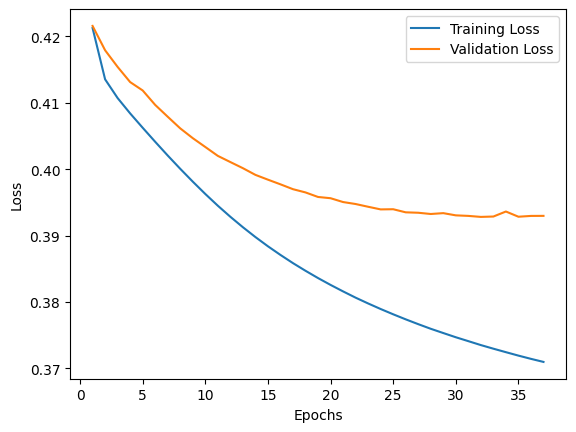

In [118]:
# Plot the training history
plt.plot(range(1, len(losses['training']) + 1), losses['training'], label='Training Loss')
plt.plot(range(1, len(losses['val']) + 1), losses['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.show()

## Generation

In [119]:
def predict_next_note(notes, model, temperature=1.0):
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch
    inputs = notes[None, :]

    model.eval()
    with torch.no_grad():
        preds = model(inputs)
        pitch_logits = preds['pitch'].squeeze(-1)
        step = preds['step'].squeeze(-1)
        duration = preds['duration'].squeeze(-1)

        pitch_logits /= temperature
        pitch = torch.multinomial(F.softmax(pitch_logits, dim=-1), num_samples=1)
        step = torch.maximum(torch.tensor(0.0), step)
        duration = torch.maximum(torch.tensor(0.0), duration)

    return int(pitch), float(step), float(duration)

In [120]:
temperature = 2.0
num_predictions = 120

sample_notes = np.array(raw_notes[key_order])

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(torch.tensor(input_notes, dtype=torch.float32).to(device), model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

In [121]:
generated_notes.head(10)

pitch      step  duration     start       end
0     45  0.104854  0.201941  0.104854  0.306795
1     58  0.112379  0.208809  0.217232  0.426041
2     72  0.111139  0.213258  0.328371  0.541628
3     73  0.108875  0.211142  0.437245  0.648388
4     77  0.105801  0.201654  0.543046  0.744700
5     69  0.097270  0.168061  0.640316  0.808377
6     65  0.088436  0.130121  0.728752  0.858873
7     72  0.087841  0.124511  0.816593  0.941104
8     84  0.087740  0.124430  0.904333  1.028763
9     65  0.088165  0.123902  0.992498  1.116400

In [122]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

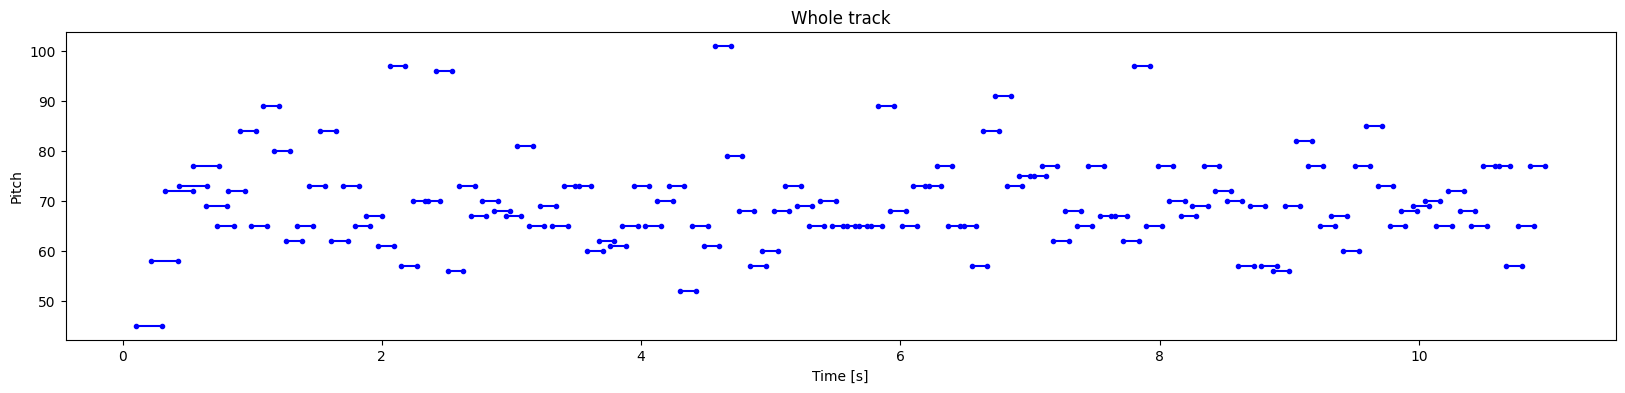

In [123]:
plot_piano_roll(generated_notes)

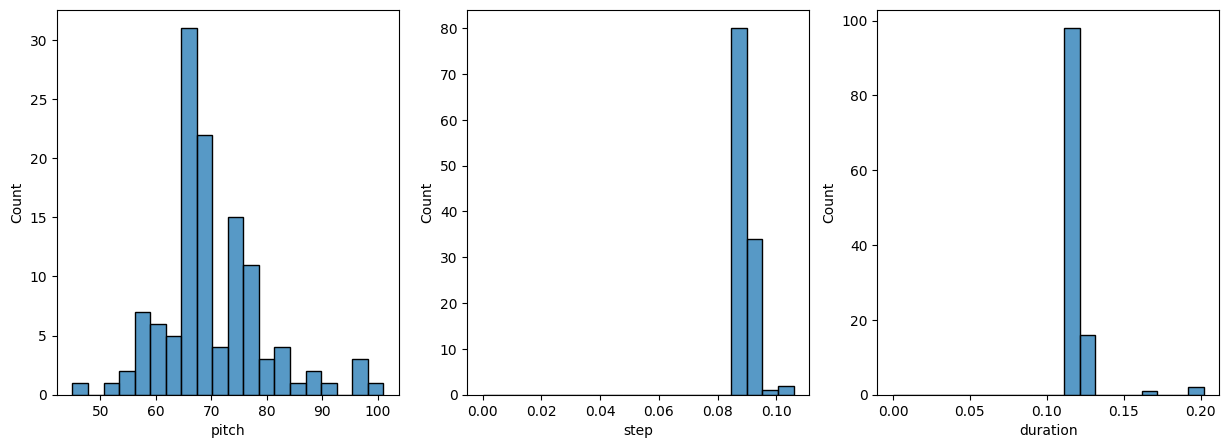

In [124]:
plot_distributions(generated_notes)

## Todo

Training/Tuning
- Increase number of files used
- Increase number of epochs
- Hyperparameter tuning (learning_rate, batch_size, hidden_dim, layers, dropout)

Formulation
- Try one_hot encoded pitch
- Try ReLU on the output of the timing variables (always > 0)
- Try normalizing the timing variables (hopefully bring the losses within the same range)
- Try using all output layer loss instead of last prediction
- Ratio of teacher forcing
- Add accuracy measurement
- Layer/Batch norm
- Data augmentation
- Include velocity
- Tokenization

Refactoring
- Clean up the generation code
- Ability to load a model checkpoint
- Load sequences directly from file to reduce RAM